# Label Generation using NDVI & NDWI
This notebook generates labels (0–3) using NDVI/NDWI


In [ ]:
!pip -q install rasterio segmentation-models-pytorch==0.3.3 torchmetrics==1.3.0 albumentations opencv-python scipy tifffile


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 8.5 MB/s eta 0:00:00
Reason for being yanked: <none given>
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 62.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 80.7 MB/s eta 0:00:00


In [ ]:
# Core
import os, json, time, random
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm

# Imaging / Geo
import rasterio
from rasterio.plot import show
from tqdm import tqdm
import tifffile
from scipy.ndimage import gaussian_filter
from PIL import Image

# DL
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# Augmentation
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Models
import segmentation_models_pytorch as smp
import torchvision
from torchvision.models.segmentation import DeepLabV3_ResNet50_Weights

# Metrics
import time
from torchmetrics.classification import MulticlassF1Score, MulticlassJaccardIndex
from torchmetrics.functional.classification import multiclass_accuracy
from torchmetrics.classification import (
    MulticlassF1Score,
    MulticlassJaccardIndex,
    MulticlassPrecision,
    MulticlassRecall,
    MulticlassAccuracy
)

# Reproducibility + device
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)


Device: cuda


**Mount Google Drive & Locate TIFF Images**

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)


Mounted at /content/drive


In [ ]:
DATA_DIR = Path("/content/drive/MyDrive/ResearchProject (1)/RGB_Prep_Demo")

tif_paths = sorted(DATA_DIR.glob("*.tif"))
print(f"Number of TIFF files: {len(tif_paths)}")
for p in tif_paths[:5]:
    print(p.name)


Number of TIFF files: 15
930645_se.tif
930650_ne.tif
930660_se.tif
930665_se.tif
930670_ne.tif


**NDVI + NDWI + BLUR Labeling Functions**

In [ ]:
def compute_ndvi(bands, red_idx=1, nir_idx=4):
    """
    bands: (bands, H, W) from rasterio
    red_idx, nir_idx are 1-based
    """
    red = bands[red_idx - 1].astype("float32")
    nir = bands[nir_idx - 1].astype("float32")
    ndvi = (nir - red) / (nir + red + 1e-6)
    return np.clip(ndvi, -1.0, 1.0)

def compute_ndwi(bands, green_idx=2, nir_idx=4):
    """
    NDWI = (Green - NIR) / (Green + NIR)
    """
    green = bands[green_idx - 1].astype("float32")
    nir = bands[nir_idx - 1].astype("float32")
    ndwi = (green - nir) / (green + nir + 1e-6)
    return np.clip(ndwi, -1.0, 1.0)

def blur_multiband(bands, sigma=1.0):
    """
    Apply Gaussian blur per band
    bands: (bands, H, W)
    """
    blurred = np.empty_like(bands, dtype=np.float32)
    for b in range(bands.shape[0]):
        blurred[b] = gaussian_filter(bands[b].astype("float32"), sigma=sigma)
    return blurred


**LABELING GENERATION FOR MASKS(0-3)**

In [ ]:
def ndvi_ndwi_to_mask(ndvi, ndwi):
    """
    Output labels:
    0 = Water
    1 = Impervious / Bare
    2 = Sparse vegetation
    3 = Dense vegetation
    """
    UNASSIGNED = 255
    mask = np.full(ndvi.shape, UNASSIGNED, dtype=np.uint8)

    # 0: Water (highest priority)
    water = (ndwi > 0.1) & (ndvi < 0.1)
    mask[water] = 0

    # 3: Dense vegetation
    mask[ndvi >= 0.5] = 3

    # 2: Sparse vegetation
    mask[(ndvi >= 0.2) & (ndvi < 0.5)] = 2

    # 1: Impervious / bare = only the pixels still UNASSIGNED
    mask[mask == UNASSIGNED] = 1

    return mask


**Visualize RGB and NDVI for a Sample TIFF**

Unique labels: [0 1 2 3]


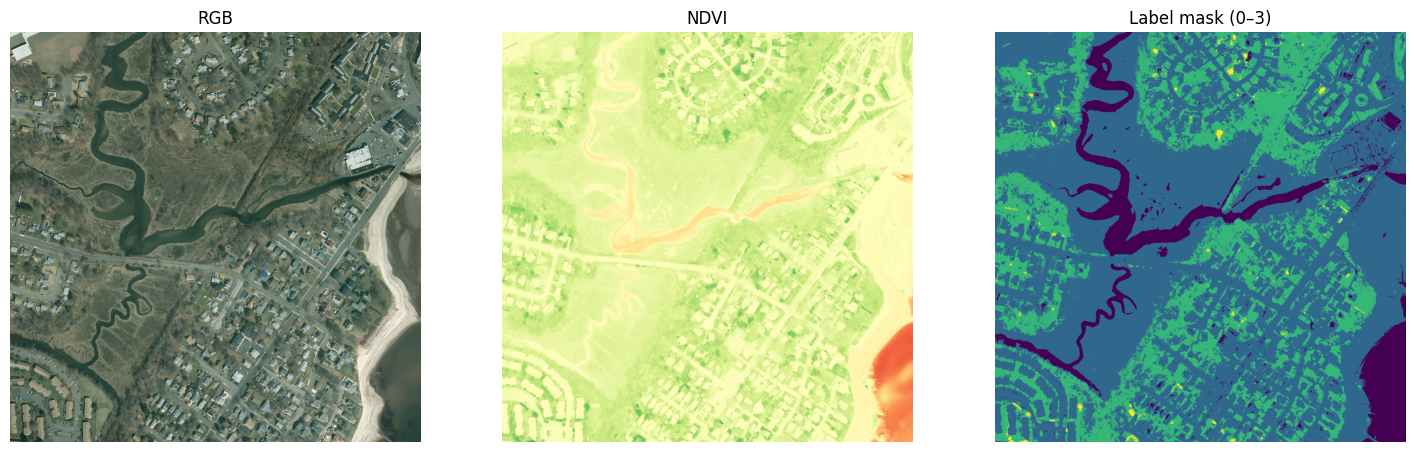

In [ ]:
sample_path = tif_paths[0]

with rasterio.open(sample_path) as src:
    bands = src.read()  # (bands, H, W)

# Optional blur (experiment toggle)
bands_blur = blur_multiband(bands, sigma=1.0)

ndvi = compute_ndvi(bands_blur)
ndwi = compute_ndwi(bands_blur)
mask = ndvi_ndwi_to_mask(ndvi, ndwi)

print("Unique labels:", np.unique(mask))

fig, axs = plt.subplots(1, 3, figsize=(18, 6))
axs[0].imshow(np.transpose(bands[:3], (1, 2, 0)) / np.max(bands[:3]))
axs[0].set_title("RGB")

axs[1].imshow(ndvi, cmap="RdYlGn", vmin=-1, vmax=1)
axs[1].set_title("NDVI")

axs[2].imshow(mask, vmin=0, vmax=3)
axs[2].set_title("Label mask (0–3)")

for ax in axs:
    ax.axis("off")

plt.show()


**Sanity check: RGB, NDVI, NDWI, mask**

Using sample: 930645_se.tif
Bands, H, W: (4, 5000, 5000)
Unique labels + counts: {0: 2184020, 1: 16090545, 2: 6617825, 3: 107610}


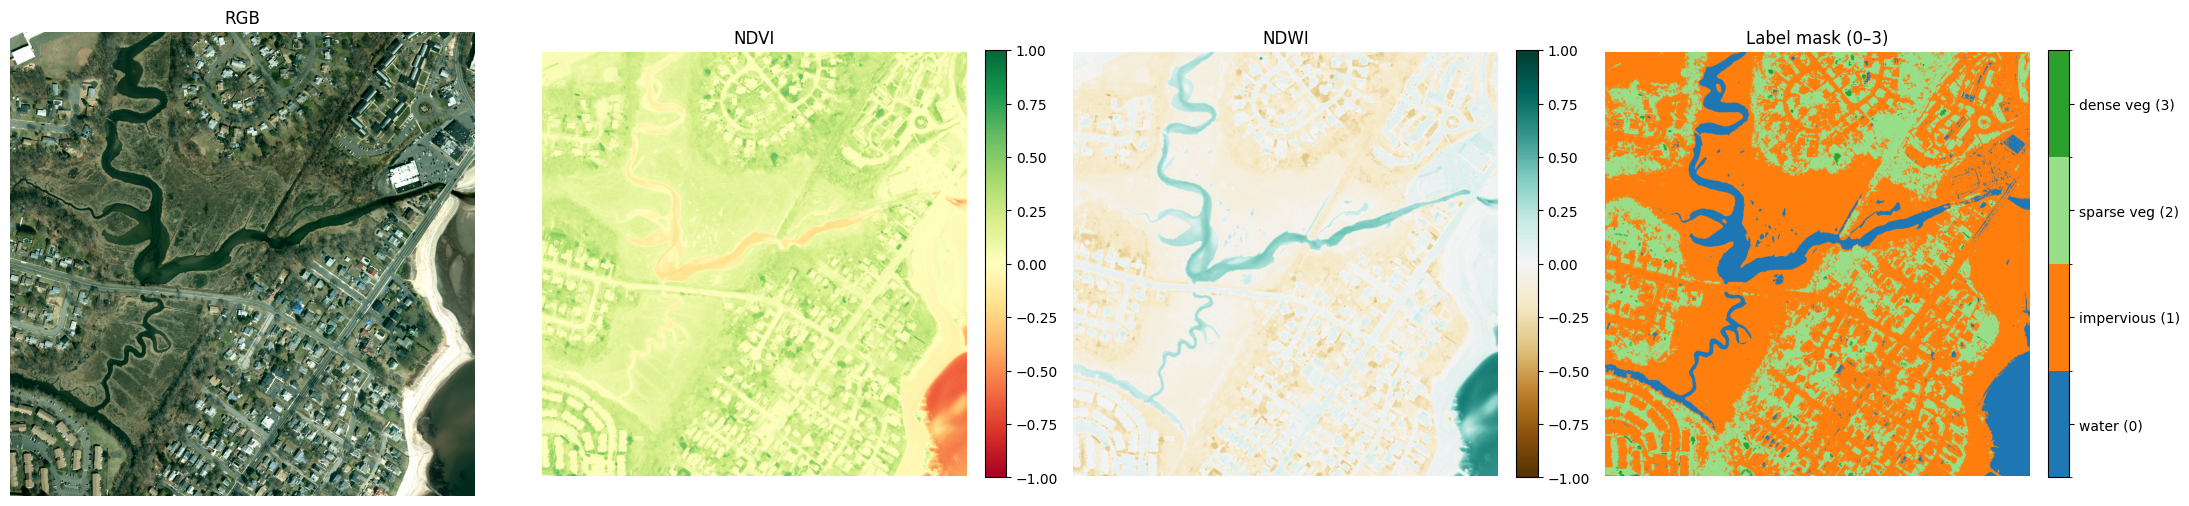

In [ ]:
sample_path = tif_paths[0]
print("Using sample:", sample_path.name)

with rasterio.open(sample_path) as src:
    bands = src.read()  # (bands, H, W)

print("Bands, H, W:", bands.shape)

# ---- Blur ----
USE_BLUR = True
sigma = 1.0
bands_for_index = blur_multiband(bands, sigma=sigma) if USE_BLUR else bands

# ---- Compute indices ----
ndvi = compute_ndvi(bands_for_index, red_idx=1, nir_idx=4)
ndwi = compute_ndwi(bands_for_index, green_idx=2, nir_idx=4)

mask = ndvi_ndwi_to_mask(ndvi, ndwi)

labels, counts = np.unique(mask, return_counts=True)
print("Unique labels + counts:", dict(zip(labels.tolist(), counts.tolist())))

# ---- RGB display (robust scaling) ----
rgb = np.transpose(bands[:3], (1, 2, 0)).astype(np.float32)
lo, hi = np.percentile(rgb, (2, 98))
rgb_disp = np.clip((rgb - lo) / (hi - lo + 1e-6), 0, 1)

# ---- Colormap for mask ----
# 0 water, 1 impervious, 2 sparse veg, 3 dense veg
class_colors = ["#1f77b4", "#ff7f0e", "#98df8a", "#2ca02c"]
cmap_mask = ListedColormap(class_colors)
norm_mask = BoundaryNorm([-0.5, 0.5, 1.5, 2.5, 3.5], ncolors=4)

# ---- Plot ----
fig, axs = plt.subplots(1, 4, figsize=(22, 6))

axs[0].imshow(rgb_disp)
axs[0].set_title("RGB")

im1 = axs[1].imshow(ndvi, cmap="RdYlGn", vmin=-1, vmax=1)
axs[1].set_title("NDVI")
plt.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)

im2 = axs[2].imshow(ndwi, cmap="BrBG", vmin=-1, vmax=1)
axs[2].set_title("NDWI")
plt.colorbar(im2, ax=axs[2], fraction=0.046, pad=0.04)

im3 = axs[3].imshow(mask, cmap=cmap_mask, norm=norm_mask)
axs[3].set_title("Label mask (0–3)")
cbar = plt.colorbar(im3, ax=axs[3], fraction=0.046, pad=0.04, ticks=[0,1,2,3])
cbar.ax.set_yticklabels(["water (0)", "impervious (1)", "sparse veg (2)", "dense veg (3)"])

for ax in axs:
    ax.axis("off")

plt.tight_layout()
plt.show()
